In [15]:
# Import necessary libraries for preprocessing, analysis, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [16]:
# Load the raw dataset containing salary data
data = pd.read_csv('Data_Science_Salaries.csv')

In [17]:
# Remove duplicate rows to ensure data integrity
data = data.drop_duplicates()

In [18]:
# Calculate interquartile range (IQR) to identify outliers in salary data
Q1 = data['salary_in_usd'].quantile(0.25)
Q3 = data['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [19]:
# Identify and filter outliers based on IQR bounds
outliers = data[(data['salary_in_usd'] < lower_bound) | (data['salary_in_usd'] > upper_bound)]

In [20]:
# Normalize numerical features to a 0-1 range using Min-Max scaling
scaler_minmax = MinMaxScaler()
data[['salary_in_usd', 'remote_ratio']] = scaler_minmax.fit_transform(data[['salary_in_usd', 'remote_ratio']])

In [21]:
# Create a new feature combining 'experience_level' and 'job_title'
if 'experience_level' in data.columns and 'job_title' in data.columns:
    data['experience_job_combination'] = data['experience_level'] + "_" + data['job_title']
else:
    raise KeyError("'experience_level' or 'job_title' is missing in the dataset.")

In [22]:
# Convert categorical variables into one-hot encoded features
categorical_columns = ['experience_level', 'job_title', 'experience_job_combination']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [23]:
# Separate features and target variable for modeling
X = data.drop(columns=['salary_in_usd'], errors='ignore')
y = data['salary_in_usd']

In [24]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Standardize numerical features for improved model performance
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler_standard = StandardScaler()
X_train_scaled = scaler_standard.fit_transform(X_train[numeric_columns])
X_test_scaled = scaler_standard.transform(X_test[numeric_columns])

In [26]:
# Perform PCA to reduce dimensionality of the dataset
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

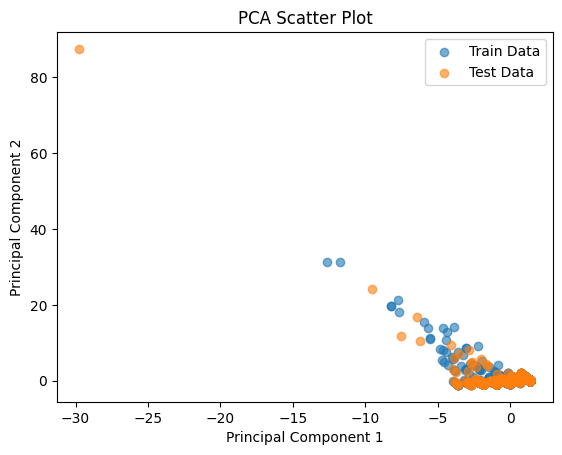

In [39]:
# Visualize the PCA components
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.6, label='Train Data')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], alpha=0.6, label='Test Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.legend()
plt.show()

In [28]:
# Display explained variance of the principal components
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by PCA: {explained_variance}")

Explained Variance by PCA: [0.41878017 0.33006489]


In [29]:
# Check if the PCA explained variance is below a threshold
if sum(explained_variance) < 0.01:
    print("PCA did not capture sufficient variance. Proceeding without PCA.")

In [30]:
# Initialize and train a Linear Regression model
model = LinearRegression()

In [31]:
# Perform cross-validation to evaluate model performance
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = -np.mean(cv_scores)
model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [32]:
# Predict and calculate evaluation metrics
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = -np.mean(cv_scores)

In [33]:
# Display evaluation metrics
evaluation_metrics = pd.DataFrame({
    "Metric": ["Mean Squared Error (Test Data)", "Cross-Validation MSE", "R² Score"],
    "Value": [mse, mean_cv_score, r2]
})
evaluation_metrics
evaluation_metrics.to_csv("Evaluation_Metrics.csv", index=False)

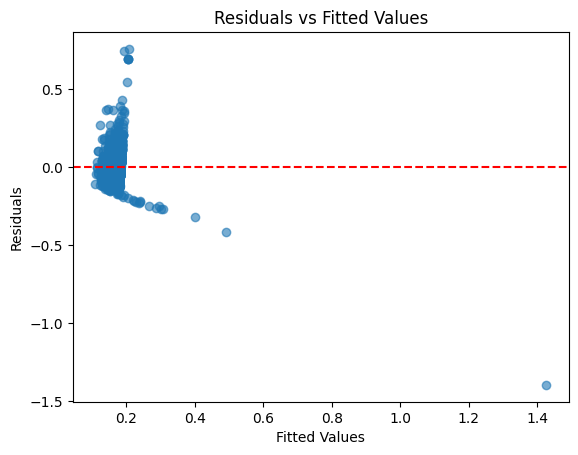

In [34]:
# Analyze residuals to assess model fit
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.savefig('Residuals_vs_Fitted.png')  
plt.show()

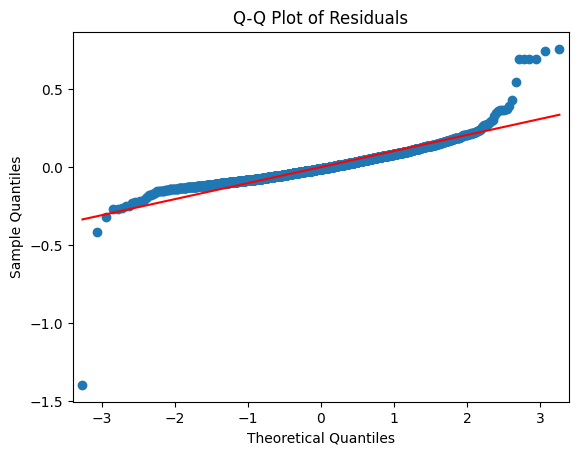

In [35]:
# Generate a Q-Q plot to check normality of residuals
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.savefig('QQ_Plot_Residuals.png')  
plt.show()

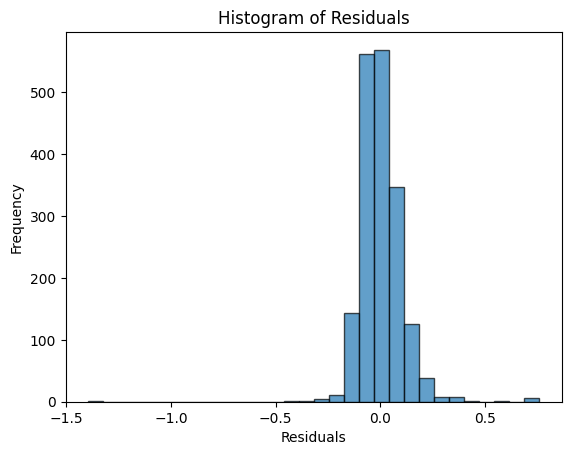

In [36]:
# Plot the histogram of residuals to check distribution
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.savefig('Histogram_Residuals.png')  
plt.show()